In [1]:
import numpy as np
import pandas as pd
import seaborn.apionly as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

import os
import codecs
import sys
import textacy

/home/tbsexton/anaconda3/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


# Automated Tagging of Maintenance Issues:
## A Keyword Detection and Ranking Approach
### Thurston Sexton + Mike Brundage
Also: compared to a Machine Learning one

In [2]:
data_directory = os.path.join('.', 'data')
raw_excel_filepath = os.path.join(data_directory, 'tag_data2.xlsx')
raw_csv_filepath = os.path.join(data_directory, 'raw_csv_tagged.csv')
vocab_filepath = os.path.join(data_directory, 'tag_vocab.csv')

In [3]:
# read in the tagged issues, which have been cleaned of nasty unicode and combined Description+Resolution
df_raw = pd.read_csv(raw_csv_filepath, encoding=sys.getfilesystemencoding(), 
                     names = ['RawText','p_Item','p_Action','s_Action','s_Item'])
# df_raw.head()

# read in the keyword dictionary and to some data-munging. 
df_vocab = pd.read_csv(vocab_filepath, header=0, encoding=sys.getfilesystemencoding(),
                       names = ['token', 'NE','alias','note'], index_col=0)
df_vocab = df_vocab.dropna(subset=['NE'])  # remove named entities that are NaN
df_vocab.alias = df_vocab.apply(lambda x: np.where(pd.isnull(x.alias), x.name, x.alias), axis=1) # alias to original if blank
df_vocab = df_vocab[~df_vocab.index.duplicated(keep='first')]

In [4]:

df_vocab.head(10)

,NE,alias,note
token,,,
replace,S,replace,NaN
unit,I,unit,NaN
motor,I,motor,NaN
spindle,I,spindle,NaN
leak,P,leak,NaN
valve,I,valve,NaN
replaced,S,replace,NaN
fault,P,fault,NaN
bar,I,bar,NaN


In [5]:
# how many instances of each keyword class are there?
print('named entities: ')
print('I\tItem\nP\tProblem\nS\tSolution\nR\tRedundant')
print('U\tUnknown\nX\tStop Word')
df_vocab.groupby("NE").nunique()

named entities: 
I	Item
P	Problem
S	Solution
R	Redundant
U	Unknown
X	Stop Word


,NE,alias,note
NE,,,
I,1,500,25
P,1,114,16
R,1,148,0
S,1,82,14
U,1,100,9
X,1,184,5


![vocab_test](vocab_test.png)

```python
# start up our NLP engine, Spacy wrapped in Textacy
docs = textacy.fileio.read.read_csv(raw_csv_filepath, encoding='utf-8')

content_stream, metadata_stream = textacy.fileio.split_record_fields(docs, 1)  # Descriptions in Col 6
corpus = textacy.Corpus(u'en', texts=content_stream, metadatas=metadata_stream)
```

In [6]:
# start up our NLP engine, Spacy wrapped in Textacy
docs = textacy.fileio.read.read_csv(raw_csv_filepath, encoding='utf-8')

content_stream, metadata_stream = textacy.fileio.split_record_fields(docs, 1)  # Descriptions in Col 6
corpus = textacy.Corpus(u'en', texts=content_stream, metadatas=metadata_stream)


```python
# THIS GENERATED THE TOP N MOST IMPORTANT TOKENS VIA A DOC_TERM_MATRIX
# the engineers used this code-snippet to make tag_vocab.csv

from unicodedata import normalize

topn = 3000
topn_tok = [id2term[i] for i in doc_term_matrix.sum(axis=0).argsort()[0,-topn:].tolist()[0][::-1]]
with open('new_top{}.txt'.format(topn), 'wb') as f:
    for i in topn_tok:
        try:
            f.write(i+'\n')
        except UnicodeEncodeError:
            print i, '-->', normalize('NFKD', i).encode('ascii','ignore')
            f.write(normalize('NFKD', i).encode('ascii','ignore') +'\n')
```            

![tag_pipe.png](tag_pipe.png)

In [7]:
def get_norm_tokens(doc_n, doc_term_mat, id2term):
    doc = doc_term_mat[doc_n].toarray()
    return [id2term[i] for i in doc.nonzero()[1]]

def doc_to_tags(tokens, thes):
#     tokens = get_norm_terms(doc)
    tags = {'I':[], 'P':[], 'S':[]}
    untagged = []
    vocab_list = thes.index.tolist()
    for tok in tokens:
        if tok in vocab_list:  # recognized token?
            typ = thes.loc[tok]['NE']
            
            if typ in tags.keys():  #  I, P, or S?
                tags[typ] = list(set(tags[typ] + [thes.loc[tok]['alias'].tolist()]))
            else:  # R or X?
                pass # skip'em
        elif np.any([i in vocab_list for i in tok.split(' ')]):
            # If any subset of `tok` is itself a recognized token, skip'em
            pass
        else: # not recognized :(
            untagged += [tok]
    return tags, list(set(untagged))
        
            
def tag_corpus(corpus, thes):
    RT, I, S, P, UK = ([], [], [], [], [])
    
    # make the tf-idf embedding to tokenize with lemma/ngrams
    doc_term_matrix, id2term = textacy.vsm.doc_term_matrix(
            (doc.to_terms_list(ngrams=(1,2,3), 
                               normalize=u'lemma',
                               named_entities=False, 
                               filter_stops=True,  # Nope! Not needed :)
                               filter_punct=True,
                               as_strings=True)
                for doc in corpus),
            weighting='tfidf', 
            normalize=False, 
            smooth_idf=False, 
            min_df=2, max_df=0.95)  # each token in >2 docs, <95% of docs
    # iterate over all issues
    for  doc_n, doc in enumerate(tqdm_notebook(corpus, 
                                               desc='tag extract loop', leave=False)):
        tokens = get_norm_tokens(doc_n, doc_term_matrix, id2term)
        tags, unknown = doc_to_tags(tokens, thes)
        UK += [', '.join(unknown)]
        RT += [doc.text]
        I += [', '.join(tags['I'])]
        S += [', '.join(tags['S'])]
        P += [', '.join(tags['P'])]
    # get back a tagged DF
    return pd.DataFrame(data={
        'RawText': RT,
        'Items': I,
        'Problem': P,
        'Solution': S,
        'UK_tok': UK  # unknown
    }, columns = ['RawText','Items','Problem','Solution','UK_tok'])

df_pred = tag_corpus(corpus, df_vocab)
df_pred.head(10)

,RawText,Items,Problem,Solution,UK_tok
0,Broken bar feeder chain. Repaired,"chain, feeder_chain, bar, bar_feeder, feeder, ...",broken,repair,
1,No power. Replaced pin in pendant and powered ...,"machine, cable, pin, pendant","power, short",replace,
2,Smartscope harness broken. Parts ordered / Tec...,"person, part",broken,"order, repair","harness, smartscope"
3,Check / Charge Accumulators. Where OK,,,"check, charge",accumulators
4,Hyd leak at saw atachment. Replaced seal in sa...,"hydraulic, saw, attachment, saw_attachment, seal",leak,replace,"reapir, ml"
5,CS1008 setup change over / from ARC1004. Compl...,"thread, thread_unit, unit",,"setup, change, wire, complete",
6,Gears on saw attachment tight and grinding per...,"saw, shelf, gear, attachment, saw_attachment, ...",tight,"rebuild, see, remove, replace",
7,Check and charge Accumulators. Checked and cha...,accumulator,,"check, charge",
8,St# 14 milling spindle repairs. Reapired,"milling, spindle, st",,repair,reapir
9,Hydraulic leak. Replaced ruptured hydraulic li...,"hydraulic, line, hydraulic_line","leak, rupture",replace,


- A lot of items are taken care of automatically. 
- where "problems" aren't listed, issue is generally routine maintenance. 
- **Assumption**: Problem and Solution tags are almost entirely independent sets. 
- We get a precise list of what *isn't* known for free...the "Unknowns". 

In [8]:
# save everything to disk
df_pred.to_excel('keyword_tagged.xlsx')

#### How many have no remaining Unknown Tokens?
i.e. the mapping from token-space (domain) --> tag-space (codomain) is a surjection in the space of this issue

In [9]:
df_pred[df_pred.UK_tok ==''].shape[0]

1687

Note that the 3438-1687 = 1751 others *apparently* have extra information to be extracted, or at least, *we cannot be certain that there isn't*.

#### How many got NO datafication?
i.e. for how many issues was this process completely worthless? 

In [10]:
# df_pred[df_pred.UK_tok ==''].dropna().shape
print(df_pred[(df_pred[['Items','Problem','Solution']]=='').all(axis=1)].shape[0])
df_pred[(df_pred[['Items','Problem','Solution']]=='').all(axis=1)]

6


,RawText,Items,Problem,Solution,UK_tok
631,Unload automation not returning.,,,,"unload, automation"
1816,.,,,,
2467,.,,,,
2571,Camshaft standstill. Gary!!,,,,camshaft
3191,Disti water empty. Water filled;,,,,"disti, fill"
3405,??.,,,,


### How well did we do at automating the job of Tagging Issues?

In order to somehow measure our success, we need something to compare with. 

Thankfully, some hard-working engineers have gone through and manually tagged over 1200 maintenance issues **by hand**. 

We can use these tags as the "gold standard" tags, with which to compare our automated keyword-->tag mapping. 

In [11]:
df_tag = pd.read_excel(raw_excel_filepath, header=1, encoding=sys.getfilesystemencoding(), 
                   names=['Description','Resolution','p_Item','p_Action','s_Action','s_Item'], parse_cols=5)
mask = df_tag[['p_Item','p_Action','s_Action','s_Item']].notnull().any(axis=1)

from itertools import chain
from sklearn.preprocessing import MultiLabelBinarizer

human_tags = [list(chain(*[tags.split(', ') for tags in issue[1].values if type(tags)==str])) 
              for issue in df_tag[['p_Item','p_Action','s_Action','s_Item']][mask].iterrows()]

recog_tags =  [list(chain(*[tags.split(', ') for tags in issue[1].values if type(tags)==str])) 
              for issue in df_pred[['Items','Problem','Solution']][mask].iterrows()]

print(human_tags[0])


multi_bin =  MultiLabelBinarizer().fit(human_tags + recog_tags)
Y_true = multi_bin.transform(human_tags)
print(Y_true[0].sum())

Y_train = multi_bin.transform(recog_tags)

['bar_feeder', 'chain', 'bar', 'broken', 'repair', 'bar_feeder', 'chain', 'bar']
5


#### But how will we measure this? 

One way is straight-forward and easy to compute...the accuracy. The **accuracy score** measures, on average, how many predicted outputs match the true outputs perfectly:

\begin{equation}
S_A = \frac{1}{n}\sum_{i=1}^{n} \mathbb{1}(T_i = P_i)
\end{equation}

#### A better alternative :

This is an *overly-harsh metric* for the performance of multilabel classification, since it ignores *how close* we got to the correct output in each case. The **hamming score** is a more forgiving and/or useful metric:
$$S_H = \frac{1}{n}\sum_{i=1}^{n} \frac{|T_i \cap P_i|}{|T_i \cup P_i|}$$
Note that the closely related **hamming loss** is similar to a distance metric, which unlike the others here is *better when low*.

#### Interpretability, please: 
Finally, we can use the slightly more intuitive **precision**, **recall**, and their harmonic mean **$F_1$-score**. As put by Scikit-Learn: 
> Intuitively, *precision* is the ability of the classifier *not to label as positive a sample that is negative*, and *recall* is the ability of the classifier *to find all the positive samples*.

Then, we can get some sort of combination that balances the two, embodied by $F_1$. Or, put formally:


$$Pr = \frac{1}{n}\sum_{i=1}^{n} \frac{|T_i \cap P_i|}{|P_i|}$$

$$Re = \frac{1}{n}\sum_{i=1}^{n} \frac{|T_i \cap P_i|}{|T_i|}$$
$$F_1 = \frac{1}{n}\sum_{i=1}^{n} \frac{2Pr_i Re_i}{Pr_i+Re_i}$$

If we want to model some difference between our importance of recall vs. precision, the generalized $F$-score is defined as:

$$F_{\beta} = \frac{1}{n}\sum_{i=1}^{n} (1+\beta^2)\frac{Pr_i Re_i}{\beta^2 Pr_i+Re_i}$$

From  Van Rijsbergen, this is defined so that $F_{\beta}$:
> "measures the effectiveness of retrieval with respect to a user who attaches $\beta$ times as much importance to recall as precision".

In our case, Since we do not really trust that the original tags given by humans were all-inclusive (i.e. they might have left out tags below some un-known relevance threshold determined by their attention [read: boredom] level), we want to place more importance on recall in our $F$-measure. We'll use the commonly-applied $F_2$

In [12]:
from sklearn.metrics import hamming_loss, accuracy_score, precision_recall_fscore_support
from scipy.stats import hmean  # harmonic mean

def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    http://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)

def f_score(y_true, y_pred, beta=1.):
    '''
    Compute the Precision, Recall, and F-beta Score for the multi-label case
    http://stackoverflow.com/q/32239577/395857
    '''
    fsc_list = []
    pre_list = []
    rec_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_p, tmp_r, tmp_f = 1, 1, 1
        elif len(set_true.intersection(set_pred)) ==0:
            tmp_p = 0
            tmp_r = 0
            tmp_f = 0
        else:
            tmp_p = len(set_true.intersection(set_pred))/\
                    float( len(set_pred) ) 
            tmp_r = len(set_true.intersection(set_pred))/\
                    float( len(set_true) )
            try:
                tmp_f = ((1.+beta**2)*tmp_p*tmp_r)/((beta**2)*tmp_p + tmp_r)
            except ValueError:
                print(tmp_p, tmp_r)
                raise
        #print('tmp_a: {0}'.format(tmp_a))
        pre_list.append(tmp_p)
        rec_list.append(tmp_r)
        fsc_list.append(tmp_f)
    return np.array(pre_list), np.array(rec_list), np.array(fsc_list)

print('---Automatic Keyword Tagging (TF-IDF+human) ---')
print('Accuracy Score: \t {:.2%}\nHamming Score: \t {:.2%}\nHamming Loss: \t {:.2e}'.format(accuracy_score(Y_true, Y_train),
                                                                          hamming_score(Y_true, Y_train),
                                                                          hamming_loss(Y_true, Y_train)))

beta=2

print('\nPrecision: \t {:.2%}\nRecall: \t {:.2%}\nF{beta} Score: \t {:.2%}'.format(
    *[np.mean(i) for i in f_score(Y_true, Y_train, beta=beta)], beta=beta
))
# print '\nPrecision: \t {:.2%}\nRecall: \t {:.2%}\nF1 Score: \t {:.2%}'.format(
#     *[np.mean(i) for i in precision_recall_fscore_support(Y_true, Y_train)[:-1]]
# )

---Automatic Keyword Tagging (TF-IDF+human) ---
Accuracy Score: 	 0.99%
Hamming Score: 	 37.99%
Hamming Loss: 	 3.61e-03

Precision: 	 44.54%
Recall: 	 68.81%
F2 Score: 	 58.85%


In [19]:
case_study = []
for n_vocab in tqdm_notebook(np.arange(100,1400, 100), 
                             desc='experiment loop'):
    res = {}
    res['df'] = tag_corpus(corpus, df_vocab.iloc[:n_vocab])
    res['n_complete'] = res['df'][res['df'].UK_tok ==''].shape[0]
    res['n_empty'] = res['df'][(res['df'][['Items','Problem','Solution']]=='').all(axis=1)].shape[0]
    
    recog_tags =  [list(chain(*[tags.split(', ') for tags in issue[1].values if type(tags)==str])) 
                   for issue in res['df'][['Items','Problem','Solution']][mask].iterrows()]
    multi_bin =  MultiLabelBinarizer().fit(human_tags + recog_tags)
    Y_true = multi_bin.transform(human_tags)
    Y_train = multi_bin.transform(recog_tags)
    
    res['hamming'] = hamming_score(Y_true, Y_train)
    res['FPR_2'] = f_score(Y_true, Y_train, beta=2)
    
    case_study += [res]
    

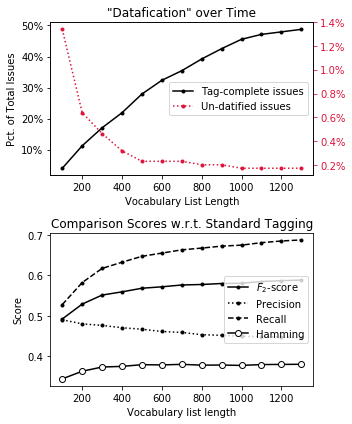

In [20]:
f,ax = plt.subplots(nrows=2, figsize=(5,6))
tagged = ax[0].plot(np.arange(100,1400, 100),
         np.array([i['n_complete'] for i in case_study])/float(df_pred.shape[0]), 
           label='Tag-complete issues', c='k', marker='.')
ax2 = ax[0].twinx()
untag = ax2.plot(np.arange(100,1400, 100),
         np.array([i['n_empty'] for i in case_study])/float(df_pred.shape[0]),
         label = "Un-datified issues", marker='.', c='crimson', ls=':')

lns = tagged + untag
labs = [l.get_label() for l in lns]
ax[0].legend(lns, labs, loc='center right')
ax2.tick_params(axis='y', colors='crimson')

ax[0].set_ylabel('Pct. of Total Issues')
ax[0].set_xlabel('Vocabulary List Length')
ax[0].set_title('"Datafication" over Time')
# ax[0].legend(, loc=0)

vals = ax[0].get_yticks()
ax[0].set_yticklabels(['{:.0%}'.format(x) for x in vals])
vals = ax2.get_yticks()
ax2.set_yticklabels(['{:.1%}'.format(x) for x in vals])

ax[1].plot(np.arange(100,1400, 100),
         [i['FPR_2'][2].mean() for i in case_study], label=u'$F_2$-score', c='k',marker='.')
ax[1].plot(np.arange(100,1400, 100),
         [i['FPR_2'][0].mean() for i in case_study], label='Precision', c='k', ls=':',marker='.')
ax[1].plot(np.arange(100,1400, 100),
         [i['FPR_2'][1].mean() for i in case_study], label='Recall', c='k', ls='--',marker='.')

ax[1].plot(np.arange(100,1400, 100),
         [i['hamming'] for i in case_study], label='Hamming', ls='-',marker='o', c='k', markerfacecolor='white')
ax[1].legend(loc='center right')
ax[1].set_ylabel('Score')
ax[1].set_xlabel('Vocabulary list length')
ax[1].set_title('Comparison Scores w.r.t. Standard Tagging')

plt.tight_layout()
plt.savefig('study.png')

## Using Machine Learning (SVM + Word2Vec)
### Benchmarking the auto-tagger

### Is there another way? 

Now, it's important to note that all of the above was done **only** with a list of categorized keywords (i.e. some mapping from token-space to tag-space), and creating that mapping did not at all depend upon some human having tagged *individual issues* already...we were just using those tagged issues as a scoring/benchmark tool. 

If we approach this as a classification problem, assuming these tagged issues *do exist*, we might attempt to train a classifier to predict the set of tags appropriate for given **raw-english** input.

#### Let's try this: 
- first a mapping from token-space to some useful vector-space (could be tf-idf, maybe a topic model, but here we will use the shiny new **Word2Vec** semantic embedding vectors of our corpus, courtesy of Google+Textacy/Spacy). 
- Then we will train a **classifier** to exactly match the **Multilabel** output, represented by the individual human-tagged issues. 

Support-vector-machines work amazingly well on text embedding classification jobs, so let's use a linear SVC trained using stochasic gradient descent (SGD) via sklearn. We should also minimize overfitting with this hugely dimensional job, so we'll regularize with an elasticnet penalty (L1+L2).  

![svm_pipe.png](svm_pipe.png)

```python 
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier

X_train = corpus.vectors[mask]
clf = OneVsRestClassifier(SGDClassifier(#class_weight='balanced',  # compensate for class freqs
                                        penalty='elasticnet'   # L1 + L2 regularized
                                        ), n_jobs=3  # 3-cores for the one-vs-all 
                         )
clf.fit(X_train, Y_true)
Y_train_w2v = clf.predict(X_train)
```

In [13]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
import warnings

X_train = corpus.vectors[mask]
clf = OneVsRestClassifier(SGDClassifier(#class_weight='balanced',  # compensate for class freqs
                                        penalty='elasticnet'   # L1 + L2 regularized
                                        ), n_jobs=-1  # cores for the one-vs-all 
                         )
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    clf.fit(X_train, Y_true);
Y_train_w2v = clf.predict(X_train)

In [14]:
print('---W2V Embeddings with SVC (OneVsRest, SGD)---')
print('Accuracy Score: \t {:.2%}\nHamming Score: \t {:.2%}\nHamming Loss: \t {:.2e}'.format(accuracy_score(Y_true, Y_train_w2v),
                                                                          hamming_score(Y_true, Y_train_w2v),
                                                                          hamming_loss(Y_true, Y_train_w2v)))
beta=2
print('\nPrecision: \t {:.2%}\nRecall: \t {:.2%}\nF{beta} Score: \t {:.2%}'.format(
    *[np.mean(i) for i in f_score(Y_true, Y_train_w2v, beta=beta)], beta=beta
))
# print '\nPrecision: \t {:.2%}\nRecall: \t {:.2%}\nF1 Score: \t {:.2%}'.format(
#     *[np.mean(i) for i in precision_recall_fscore_support(Y_true, Y_train_w2v)[:-1]]
# )

---W2V Embeddings with SVC (OneVsRest, SGD)---
Accuracy Score: 	 11.96%
Hamming Score: 	 46.64%
Hamming Loss: 	 2.21e-03

Precision: 	 69.26%
Recall: 	 58.12%
F2 Score: 	 56.92%


In [46]:
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from time import time
import warnings


parameters = {
    'estimator__alpha': (1e-3, 1e-4, 1e-5),
    'estimator__penalty': ('l1', 'l2', 'elasticnet'),
    'estimator__n_iter': (1, 5, 10),
    'estimator__loss': ('hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron')
}

grid_search = GridSearchCV(clf, parameters, verbose=1, n_jobs=-1)

print("Performing grid search...")
print("parameters:")
pprint(parameters)
t0 = time()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    grid_search.fit(X_train, Y_true)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
parameters:
{'estimator__alpha': (0.001, 0.0001, 1e-05),
 'estimator__loss': ('hinge',
                     'log',
                     'modified_huber',
                     'squared_hinge',
                     'perceptron'),
 'estimator__n_iter': (1, 5, 10),
 'estimator__penalty': ('l1', 'l2', 'elasticnet')}
Fitting 3 folds for each of 135 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   55.4s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed: 17.5min finished


done in 1055.964s

Best score: 0.106
Best parameters set:
	estimator__alpha: 0.001
	estimator__loss: 'log'
	estimator__n_iter: 5
	estimator__penalty: 'l2'


In [47]:
Y_train_cv = grid_search.predict(X_train)

print('---W2V Embeddings with SVC (CV, OneVsRest, SGD)---')
print('Accuracy Score: \t {:.2%}\nHamming Score: \t {:.2%}\nHamming Loss: \t {:.2e}'.format(accuracy_score(Y_true, Y_train_cv),
                                                                          hamming_score(Y_true, Y_train_cv),
                                                                          hamming_loss(Y_true, Y_train_cv)))
beta=2
print('\nPrecision: \t {:.2%}\nRecall: \t {:.2%}\nF{beta} Score: \t {:.2%}'.format(
    *[np.mean(i) for i in f_score(Y_true, Y_train_cv, beta=beta)], beta=beta
))
# print '\nPrecision: \t {:.2%}\nRecall: \t {:.2%}\nF1 Score: \t {:.2%}'.format(
#     *[np.mean(i) for i in precision_recall_fscore_support(Y_true, Y_train_w2v)[:-1]]
# )

---W2V Embeddings with SVC (CV, OneVsRest, SGD)---
Accuracy Score: 	 14.00%
Hamming Score: 	 34.16%
Hamming Loss: 	 2.42e-03

Precision: 	 61.84%
Recall: 	 37.27%
F2 Score: 	 38.50%


In [19]:
# from __future__ import print_function
from ipywidgets import interact, interactive
import ipywidgets as widgets
from IPython.display import display

def compare_by_issue(iss):
    print('Issue No. ',iss)
    print(df_pred[mask]['RawText'].iloc[iss])
    print('\nHuman-tagged \"True\" Keyworks/Tags: \t{}'.format(', '.join(sorted(multi_bin.inverse_transform(Y_true)[iss]))))

    print('\nTF-IDF rank Human-classified keywords: \t{}'.format(', '.join(sorted(multi_bin.inverse_transform(Y_train)[iss]))))
    print('Precision: \t {:.2%}\nRecall: \t {:.2%}\nF2 Score: \t {:.2%}'.format(
        *[i[iss] for i in f_score(Y_true, Y_train, beta=2.)]
    ))
    print('\nWord2Vec + SVM Multilabel Classifier: \t{}'.format(', '.join(sorted(multi_bin.inverse_transform(Y_train_w2v)[iss]))))
    print('Precision: \t {:.2%}\nRecall: \t {:.2%}\nF2 Score: \t {:.2%}'.format(
        *[i[iss] for i in f_score(Y_true, Y_train_w2v, beta=2.)]
    ))
# compare_by_issue(0)

In [50]:
svm_study = []
for n_vocab in tqdm_notebook(range(30)):
    res = {}
    
#     res['clf'] = OneVsRestClassifier(SGDClassifier(#class_weight='balanced',  # compensate for class freqs
#                                             penalty='elasticnet',   # L1 + L2 regularized
#                                             n_iter=80,
#                                                 alpha=0.001
#                                             ), n_jobs=-1  # all cores for the one-vs-all 
#                               )
    res['clf'] = OneVsRestClassifier(SGDClassifier(#class_weight='balanced',  # compensate for class freqs
                                            penalty='l2',   # L1 + L2 regularized
                                            n_iter=5,
                                            alpha=0.001,
                                            loss='log'
                                            ), n_jobs=-1  # all cores for the one-vs-all 
                                    )
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        res['clf'].fit(X_train, Y_true)
    Y_train_w2v = res['clf'].predict(X_train)
    
    res['hamming'] = hamming_score(Y_true, Y_train_w2v)
    res['FPR_2'] = f_score(Y_true, Y_train_w2v, beta=2)
    
    svm_study += [res]

In [51]:
from scipy.stats import iqr

df_svm = pd.DataFrame.from_dict(data={u'$Pr$': np.array([i['FPR_2'][0].mean() for i in svm_study]),
                            u'$Re$': np.array([i['FPR_2'][1].mean() for i in svm_study]),
                            u'$F_2$':np.array([i['FPR_2'][2].mean() for i in svm_study]),
                            u'$S_H$':np.array([i['hamming'] for i in svm_study])}
                     )
# sns.distplot(df_svm[u'$S_H$'])
def IQR(a):
    return np.subtract(*np.percentile(a, [75, 25]))

pd.DataFrame({'Median':df_svm.agg('median'), 'IQR':df_svm.agg(IQR)})


,IQR,Median
$F_2$,0.018244,0.364804
$Pr$,0.033914,0.607965
$Re$,0.018849,0.352737
$S_H$,0.013813,0.327140


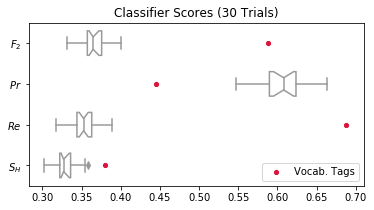

In [55]:
plt.figure(figsize=(6,3))
sns.boxplot(data=df_svm, orient='h', width=.6, color='white', notch=True, bootstrap=10000)
plt.scatter([.5885, .4454, .6881,.3799], [0,1,2,3], c='crimson', marker='.', s=70, label='Vocab. Tags')
plt.legend()
plt.title('Classifier Scores (30 Trials)')
# plt.boxplot()

Wow, that's pretty fantastic, considering the task we've set before it! Better performance, at least on a per-metric level, than our automated keyword-tagger in every way! 

Still, note that the precision is almost 80%...this may or may not be a model we want to actually use early on, given that we may or may not trust our engineers' tagging job. Assuming We 100% trust the keyword flagger when it recognizes a word, the precision of that one is actually 100%, and any discrepancy is on the part of *the original tags*. 

Another way to look at it is our keyword tagger is being really nit-picky and overly-accurate, which precision is punishing. Our classifier, on the other hand, is being trained *to tag like the humans*. 

Let's dig in a bit.. To get a more fine-grained idea of what's going on, we can also look at the Pr/Re/F scores on an individual-issue level to get a better idea of the performance of each model. 

In [20]:
interact(compare_by_issue, iss=widgets.BoundedIntText(
                    value=0,
                    min=0,
                    max=3437,
                    description='Pick an Issue No.:',
                    step=1
                    )
               );
# display(w)

# Analysis

Now that we have tags, what do we do with them?


- **MaxLikelihood Example Demo**
- **Something simpler?**

First let's get some of the most common tags and convert them into binary indicators on a per-issue basis. 

In [21]:
def get_relevant(df, col, topn=20):
    
    tags = [x[1][col].split(', ') for x in df.iterrows()]
    binner = MultiLabelBinarizer().fit(tags)
    vecs = binner.transform(tags)
    counts = vecs.sum(axis=0)
    relevant = [(binner.classes_[i], counts[i], vecs[:,i]) for i in counts.argsort()[-topn:][::-1]]
    return relevant

relevant = get_relevant(df_pred, 'Items', topn=20) +\
get_relevant(df_pred, 'Problem', topn=20) +\
get_relevant(df_pred, 'Solution', topn=20)
print('e.g. ...')
relevant[:10]

e.g. ...


[('unit', 366, array([0, 0, 0, ..., 0, 0, 0])),
 ('spindle', 297, array([0, 0, 0, ..., 0, 0, 0])),
 ('hydraulic', 275, array([0, 0, 0, ..., 0, 1, 1])),
 ('motor', 248, array([0, 0, 0, ..., 0, 0, 0])),
 ('valve', 234, array([0, 0, 0, ..., 0, 0, 1])),
 ('bar', 232, array([1, 0, 0, ..., 0, 0, 0])),
 ('accumulator', 204, array([0, 0, 0, ..., 0, 0, 0])),
 ('machine', 204, array([0, 1, 0, ..., 0, 0, 0])),
 ('coolant', 198, array([0, 0, 0, ..., 0, 0, 0])),
 ('person', 190, array([0, 0, 1, ..., 0, 0, 0]))]

In [22]:
# item_counts = Item_vecs.sum(axis=0)
# relevant = [(binner.classes_[i], item_counts[i], Item_vecs[:,i]) for i in item_counts.argsort()[-20:][::-1]]
event_df = pd.DataFrame(columns = [i[0] for i in relevant if i[0]!=u''], 
             data = np.array([i[2] for i in relevant if i[0]!=u'']).T)
# plt.barh()
event_df.head(10)

,unit,spindle,hydraulic,motor,valve,bar,accumulator,machine,coolant,person,...,charge,reset,clear,swap,load,cycle,level,check_request,report,train_operator
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
8,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now we want to get other information, say, the *time* a problem was submitted. 

In [23]:
# og_data_loc = os.path.join(data_directory, 'Maintenance_All_Clean.xlsx')
og_data = pd.read_excel(raw_excel_filepath,header=1, parse_dates=True, index_col='DATE RECEIVED')
                        #[['DATE RECEIVED','Time Submitted']])
# og_data.set_index('DATE RECEIVED_Time Submitted', inplace=True)
# og_data.set_index('DATE RECEIVED', inplace=True)

# print og_data.iloc[1381]
og_data.head()

,Description,Resolution,Item Tags,Action Tags,Action Tags.1,Item Tags.1,Unnamed: 6,MACH,DOWN Y/N,Time Submitted,DATE COMPLETED,Time Up,REQUESTED BY,TECH,Tech Full Name,Part in Process,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20
DATE RECEIVED,,,,,,,,,,,,,,,,,,,,
2015-01-11,Broken bar feeder chain,Repaired,"bar_feeder, chain, bar",broken,repair,"bar_feeder, chain, bar",NaN,H27,Y,NaN,2015-01-11 00:00:00,NaN,Alex,AP,Anthony Paolillo,NaN,NaN,NaN,NaN,NaN
2015-01-14,No power,Replaced pin in pendant and powered machine -P...,"pendant_cable, cable","short, no_power",replace,pin,NaN,H5,Y,NaN,2015-11-16 00:00:00,NaN,Bruce,JPM / AP,John Murray/ Anthony Paolillo,NaN,DK,Denis Kusiak,NaN,Mike: 7.5 hours
2015-02-27,Smartscope harness broken,Parts ordered / Tech repaired,smartscope_harness,broken,"order, repair",smartscope_harness,NaN,QA,Y,NaN,2015-02-27 00:00:00,NaN,QA,DK / Tech,Denis Kusiak/ Technician,NaN,NaN,NaN,NaN,Thurston: 4 hours
2015-02-27,Check / Charge Accumulators,Where OK,accumulator,"check, charge",no_problem_detected,NaN,NaN,H18,N,NaN,2015-02-27 00:00:00,NaN,Steve C,SA,Steve Andreozzi,NaN,NaN,NaN,NaN,NaN
2015-02-27,Hyd leak at saw atachment,Replaced seal in saw attachment but still leak...,"hydraulic, saw_attachment, saw",leak,"replace, need_guy",seal,NaN,H23,N,NaN,2015-02-27 00:00:00,NaN,Steve C,JPM,John Murray,NaN,NaN,NaN,NaN,NaN


and then, re-index our indicator items. 

In [24]:
df_raw.head()
event_df.index = og_data.index
event_df.index = pd.to_datetime(event_df.index, errors='coerce')
event_df.iloc[2500:2505]

,unit,spindle,hydraulic,motor,valve,bar,accumulator,machine,coolant,person,...,charge,reset,clear,swap,load,cycle,level,check_request,report,train_operator
DATE RECEIVED,,,,,,,,,,,,,,,,,,,,,
2016-08-01,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-08-01,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-08-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-08-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-08-01,0,0,0,0,0,0,0,0,1,0,...,0,1,1,0,0,0,0,0,0,0


In [25]:
"""
Calendar heatmaps from Pandas time series data.
Plot Pandas time series data sampled by day in a heatmap per calendar year,
similar to GitHub's contributions calendar.

adapted from:
    'Martijn Vermaat' 14 Feb 2016
    'martijn@vermaat.name'
    'https://github.com/martijnvermaat/calmap'
"""
from __future__ import unicode_literals

import calendar
import datetime

from matplotlib.colors import ColorConverter, ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from distutils.version import StrictVersion

_pandas_18 = StrictVersion(pd.__version__) >= StrictVersion('0.18')


def yearplot(data, year=None, how='sum', vmin=None, vmax=None, cmap='Reds',
             fillcolor='whitesmoke', linewidth=1, linecolor=None,
             daylabels=calendar.day_abbr[:], dayticks=True,
             monthlabels=calendar.month_abbr[1:], monthticks=True, ax=None,
             **kwargs):
    """
    Plot one year from a timeseries as a calendar heatmap.
    Parameters
    ----------
    data : Series
        Data for the plot. Must be indexed by a DatetimeIndex.
    year : integer
        Only data indexed by this year will be plotted. If `None`, the first
        year for which there is data will be plotted.
    how : string
        Method for resampling data by day. If `None`, assume data is already
        sampled by day and don't resample. Otherwise, this is passed to Pandas
        `Series.resample`.
    vmin, vmax : floats
        Values to anchor the colormap. If `None`, min and max are used after
        resampling data by day.
    cmap : matplotlib colormap name or object
        The mapping from data values to color space.
    fillcolor : matplotlib color
        Color to use for days without data.
    linewidth : float
        Width of the lines that will divide each day.
    linecolor : color
        Color of the lines that will divide each day. If `None`, the axes
        background color is used, or 'white' if it is transparent.
    daylabels : list
        Strings to use as labels for days, must be of length 7.
    dayticks : list or int or bool
        If `True`, label all days. If `False`, don't label days. If a list,
        only label days with these indices. If an integer, label every n day.
    monthlabels : list
        Strings to use as labels for months, must be of length 12.
    monthticks : list or int or bool
        If `True`, label all months. If `False`, don't label months. If a
        list, only label months with these indices. If an integer, label every
        n month.
    ax : matplotlib Axes
        Axes in which to draw the plot, otherwise use the currently-active
        Axes.
    kwargs : other keyword arguments
        All other keyword arguments are passed to matplotlib `ax.pcolormesh`.
    Returns
    -------
    ax : matplotlib Axes
        Axes object with the calendar heatmap.
    Examples
    --------
    By default, `yearplot` plots the first year and sums the values per day:
    .. plot::
        :context: close-figs
        calmap.yearplot(events)
    We can choose which year is plotted with the `year` keyword argment:
    .. plot::
        :context: close-figs
        calmap.yearplot(events, year=2015)
    The appearance can be changed by using another colormap. Here we also use
    a darker fill color for days without data and remove the lines:
    .. plot::
        :context: close-figs
        calmap.yearplot(events, cmap='YlGn', fillcolor='grey',
                        linewidth=0)
    The axis tick labels can look a bit crowded. We can ask to draw only every
    nth label, or explicitely supply the label indices. The labels themselves
    can also be customized:
    .. plot::
        :context: close-figs
        calmap.yearplot(events, monthticks=3, daylabels='MTWTFSS',
                        dayticks=[0, 2, 4, 6])
    """
    if year is None:
        year = data.index.sort_values()[0].year

    if how is None:
        # Assume already sampled by day.
        by_day = data
    else:
        # Sample by day.
        if _pandas_18:
            by_day = data.resample('W').agg(how)
        else:
            by_day = data.resample('W', how=how)

    # Min and max per day.
    if vmin is None:
        vmin = by_day.min().min()
    if vmax is None:
        vmax = by_day.max().max()

    if ax is None:
        ax = plt.gca()

    if linecolor is None:
        # Unfortunately, linecolor cannot be transparent, as it is drawn on
        # top of the heatmap cells. Therefore it is only possible to mimic
        # transparent lines by setting them to the axes background color. This
        # of course won't work when the axes itself has a transparent
        # background so in that case we default to white which will usually be
        # the figure or canvas background color.
        linecolor = ax.get_axis_bgcolor()
        if ColorConverter().to_rgba(linecolor)[-1] == 0:
            linecolor = 'white'

    # Filter on year.
    by_day = by_day[by_day.index.year==year]

    # Add missing days.

    plot_data = by_day.transpose().fillna(0)

    # Draw heatmap.
    kwargs['linewidth'] = linewidth
    kwargs['edgecolors'] = linecolor
    ax.pcolormesh(plot_data, vmin=vmin, vmax=vmax, cmap=cmap, **kwargs)
    # Limit heatmap to our data.
    ax.set(xlim=(0, plot_data.shape[1]), ylim=(0, plot_data.shape[0]))

    # Square cells.
    ax.set_aspect('equal')

    # Remove spines and ticks.
    for side in ('top', 'right', 'left', 'bottom'):
        ax.spines[side].set_visible(False)
    ax.xaxis.set_tick_params(which='both', length=0)
    ax.yaxis.set_tick_params(which='both', length=0)

    # Get indices for monthlabels.
    if monthticks is True:
        monthticks = range(len(monthlabels))
    elif monthticks is False:
        monthticks = []
    elif isinstance(monthticks, int):
        monthticks = range(len(monthlabels))[monthticks // 2::monthticks]

    # Get indices for daylabels.
    if dayticks is True:
        dayticks = range(len(daylabels))
    elif dayticks is False:
        dayticks = []
    elif isinstance(dayticks, int):
        dayticks = range(len(daylabels))[dayticks // 2::dayticks]
    ax.set_xlabel('')
    ax.set_xticklabels([monthlabels[i] for i in monthticks], ha='center')
    
    ax.set_xticks([pd.Timestamp('{}/15/{}'.format(i, year)).week-1.5 for i in range(1,13)])
    ax.set_ylabel('')
    ax.yaxis.set_ticks_position('right')
    ax.set_yticks([by_day.columns.shape[0] - i - .5  for i in range(by_day.columns.shape[0])])
    ax.set_yticklabels(by_day.columns[::-1], rotation='horizontal',
                       va='center')

    return ax

def calendarplot(data, how='sum', yearlabels=True, yearascending=True, yearlabel_kws=None,
                 subplot_kws=None, gridspec_kws=None, fig_kws=None, **kwargs):
    """
    Plot a timeseries as a calendar heatmap.
    Parameters
    ----------
    data : Series
        Data for the plot. Must be indexed by a DatetimeIndex.
    how : string
        Method for resampling data by day. If `None`, assume data is already
        sampled by day and don't resample. Otherwise, this is passed to Pandas
        `Series.resample`.
    yearlabels : bool
       Whether or not to draw the year for each subplot.
    yearascending : bool
       Sort the calendar in ascending or descending order.
    yearlabel_kws : dict
       Keyword arguments passed to the matplotlib `set_ylabel` call which is
       used to draw the year for each subplot.
    subplot_kws : dict
        Keyword arguments passed to the matplotlib `add_subplot` call used to
        create each subplot.
    gridspec_kws : dict
        Keyword arguments passed to the matplotlib `GridSpec` constructor used
        to create the grid the subplots are placed on.
    fig_kws : dict
        Keyword arguments passed to the matplotlib `figure` call.
    kwargs : other keyword arguments
        All other keyword arguments are passed to `yearplot`.
    Returns
    -------
    fig, axes : matplotlib Figure and Axes
        Tuple where `fig` is the matplotlib Figure object `axes` is an array
        of matplotlib Axes objects with the calendar heatmaps, one per year.
    Examples
    --------
    With `calendarplot` we can plot several years in one figure:
    .. plot::
        :context: close-figs
        calmap.calendarplot(events)
    """
    yearlabel_kws = yearlabel_kws or {}
    subplot_kws = subplot_kws or {}
    gridspec_kws = gridspec_kws or {}
    fig_kws = fig_kws or {}

    years = np.unique(data.index.year)
    if not yearascending:
        years = years[::-1]

    fig, axes = plt.subplots(nrows=len(years), ncols=1, squeeze=False,
                             subplot_kw=subplot_kws,
                             gridspec_kw=gridspec_kws, **fig_kws)
    axes = axes.T[0]

    # We explicitely resample by day only once. This is an optimization.
    if how is None:
        by_day = data
    else:
        if _pandas_18:
            by_day = data.resample('W').agg(how)
        else:
            by_day = data.resample('W', how=how)

    ylabel_kws = dict(
        fontsize=32,
        color=kwargs.get('fillcolor', 'xkcd:wheat'),
        fontweight='bold',
        fontname='Arial',
        ha='center')
    ylabel_kws.update(yearlabel_kws)

    max_weeks = 0

    for year, ax in zip(years, axes):
        yearplot(by_day, year=year, how=None, ax=ax, **kwargs)
        max_weeks = max(max_weeks, ax.get_xlim()[1])

        if yearlabels:
            ax.set_ylabel(str(year), **ylabel_kws)

    # In a leap year it might happen that we have 54 weeks (e.g., 2012).
    # Here we make sure the width is consistent over all years.
    for ax in axes:
        ax.set_xlim(0, max_weeks)

    # Make the axes look good.
    plt.tight_layout()

    return fig, axes

Let's pick a few interesting items, and see how often they come up as a problem/solution: 

/home/tbsexton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:128: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.


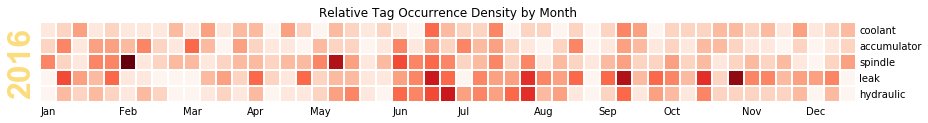

In [26]:
# plt.figure
calendarplot(event_df[['hydraulic',
                       'leak',
                       'spindle',
                       'accumulator',
                       'coolant'
                       ]][event_df.index.year==2016],
             how='sum', fig_kws={'figsize':(13,9)});
plt.title('Relative Tag Occurrence Density by Month')
# yearplot(event_df[['hydraulic', 'spindle','accumulator', 'operator']], how='sum', fig_kws={'figsize':(12,8)})
# og_data[event_df.index.isnull()]

In [27]:
event_df[event_df.operator==1].sum().to_frame(name='operator_incidents').sort_values('operator_incidents', 
                                                                                     ascending=False).iloc[:10]

,operator_incidents
operator,162
level,67
train_operator,64
replace,32
fault,29
loose,26
bar,20
broken,20
machine,19
remove,17


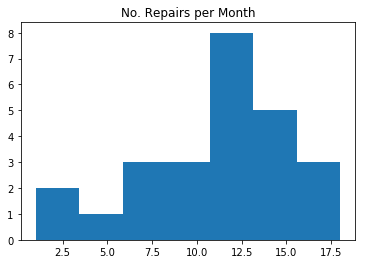

In [28]:
week_df = event_df.resample('M').agg(sum).fillna(0)
plt.hist(week_df['repair'].values, bins='auto')
plt.title('No. Repairs per Month')

## Beginning of Prognostics
We need to approximate the idea of "machine failure" as opposed to "machine maintenance" (compare to "patient care" vs. "patient death". 

One way is to only find items occuring with "broken" **AND** "replace". While not 100% accurate, it's definitely a quick and dirty way to estimate the failure rate.  

/home/tbsexton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:128: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.


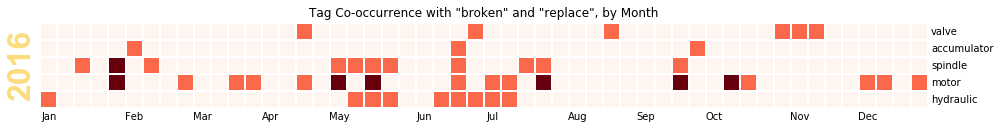

In [29]:
weekly_replace = event_df[(event_df['broken']==1) & (event_df['replace']==1)].resample('W').agg(sum).fillna(0)
calendarplot(weekly_replace[['hydraulic',
                             'motor',
                             'spindle',
                             'accumulator',
                             'valve'
                            ]][weekly_replace.index.year==2016], 
             fig_kws={'figsize':(14,8)});
plt.title('Tag Co-occurrence with "broken" and "replace", by Month')

/home/tbsexton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


expected interarrival time
spindle fail:	25.11 days
motor fail:	17.44 days


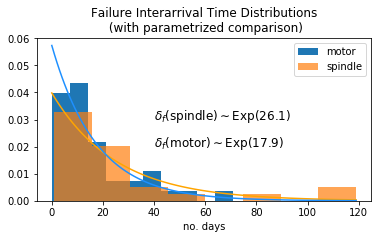

In [30]:
from scipy.stats import norm, expon
def get_fail_iat(event_df, tag):
    fail_time_valve = event_df[(event_df['broken']==1) & (event_df['replace']==1) & (event_df[tag]==1)]
    fail_time_valve['date']=fail_time_valve.index
    fail_time_valve.index = range(fail_time_valve.shape[0])
    iat_valve = fail_time_valve['date']-fail_time_valve.shift()['date']
    return iat_valve

plt.figure(figsize=(6,3))
plt.hist((get_fail_iat(event_df, 'motor')/ pd.Timedelta(days=1)).values[1:], label='motor',
                                                             normed=True)
plt.title('Failure Interarrival Time Distributions\n (with parametrized comparison)')
plt.xlabel('no. days')

plt.hist((get_fail_iat(event_df, 'spindle')/ pd.Timedelta(days=1)).values[1:], label='spindle', 
                                                               alpha=.7, normed=True, bins='auto')
# plt.title('Motor Failure\n Interarrival Times')
# plt.xlabel('no. days')

print('expected interarrival time')
print('spindle fail:\t{:.2f} days'.format((get_fail_iat(event_df, 'spindle')/ pd.Timedelta(days=1)).mean()))
plt.plot(range(120), expon(scale=(get_fail_iat(event_df, 'spindle')/ pd.Timedelta(days=1)).mean()).pdf(np.arange(120)),
        color='orange')

print('motor fail:\t{:.2f} days'.format((get_fail_iat(event_df, 'motor')/ pd.Timedelta(days=1)).mean()))
plt.plot(range(120), expon(scale=(get_fail_iat(event_df, 'motor')/ pd.Timedelta(days=1)).mean()).pdf(np.arange(120)),
        color='dodgerblue')
plt.grid(b=False)
plt.legend()

plt.text(40, 0.03, r'$\delta_f(\mathrm{spindle})\sim\mathrm{Exp}(26.1)$',
         fontsize=12)
plt.text(40, 0.02, r'$\delta_f(\mathrm{motor})\sim\mathrm{Exp}(17.9)$',
         fontsize=12)

# Taxonomy Generation

It would be great if we had organized all of these tags, determining which ones are more general or specific. 

It would be even better if we had a starting point to do that, done for us. 

### Graph Theory I

Retrieving those same binary vectors for the top Items, lets call them $\bf{B}$. What we want is an idea of how many times particular tags happen together. 

Luckily, this is $B^{T}B$ 

In [33]:
itm_relevant = get_relevant(df_pred, 'Items', topn=700)
itm_event = pd.DataFrame(columns = [i[0] for i in itm_relevant if i[0]!=u''], 
             data = np.array([i[2] for i in itm_relevant if i[0]!=u'']).T)



In [34]:
coocc = itm_event.T.dot(itm_event)
occ = np.diagonal(np.copy(coocc))

np.fill_diagonal(coocc.values, 0)
coocc.head()


,unit,spindle,hydraulic,motor,valve,bar,accumulator,machine,coolant,person,...,high_pressure_coolant_hose,valve_stem,hinge,hinge_belt,loader_tray,direct_current,pneumatic,bar_feed,intake_filter,valve_plate
unit,0,30,29,60,16,5,8,10,7,26,...,0,0,0,0,0,0,0,0,0,0
spindle,30,0,22,20,24,8,2,14,3,22,...,0,0,0,0,0,0,0,0,0,0
hydraulic,29,22,0,23,51,8,15,12,6,15,...,0,1,0,0,0,2,0,0,2,2
motor,60,20,23,0,2,1,1,8,23,14,...,0,0,0,0,0,2,1,0,0,0
valve,16,24,51,2,0,12,9,11,8,12,...,0,3,0,0,0,0,0,0,0,2


Actually, $B^{T}B$ contains the overall occurrence count in it's diagonal. What we are actually using is $B^{T}B-\text{diag}(B^{T}B)$, which is called an *adjacency* graph. 

### Graph Theory II

One way to analyse this is using some notion of **node similarity**. There are a few different ways of measuring the similarity of tags, but one straight-forward one is the ever-popular *cosine similarity*. In the context of co-occurnce graphs, we can caclulate this as 

$$ \frac{n_{x,y}}{\sqrt{n_x}\sqrt{n_y}} $$

Where $n_x$, $n_y$, and $n_{x,y}$ are the number of "issues" or documents tagged with the tag, $x$, $y$, or $x\cup y$, respectively. This makes for a nice edge weigting on our cooccurrence graph. 

In [35]:
dist_mat = coocc/np.dot(np.sqrt(occ).T, np.sqrt(occ))

dist_mat.head()

,unit,spindle,hydraulic,motor,valve,bar,accumulator,machine,coolant,person,...,high_pressure_coolant_hose,valve_stem,hinge,hinge_belt,loader_tray,direct_current,pneumatic,bar_feed,intake_filter,valve_plate
unit,0.000000,0.002103,0.002033,0.004206,0.001122,0.000350,0.000561,0.000701,0.000491,0.001823,...,0.0,0.00000,0.0,0.0,0.0,0.00000,0.00000,0.0,0.00000,0.00000
spindle,0.002103,0.000000,0.001542,0.001402,0.001682,0.000561,0.000140,0.000981,0.000210,0.001542,...,0.0,0.00000,0.0,0.0,0.0,0.00000,0.00000,0.0,0.00000,0.00000
hydraulic,0.002033,0.001542,0.000000,0.001612,0.003575,0.000561,0.001051,0.000841,0.000421,0.001051,...,0.0,0.00007,0.0,0.0,0.0,0.00014,0.00000,0.0,0.00014,0.00014
motor,0.004206,0.001402,0.001612,0.000000,0.000140,0.000070,0.000070,0.000561,0.001612,0.000981,...,0.0,0.00000,0.0,0.0,0.0,0.00014,0.00007,0.0,0.00000,0.00000
valve,0.001122,0.001682,0.003575,0.000140,0.000000,0.000841,0.000631,0.000771,0.000561,0.000841,...,0.0,0.00021,0.0,0.0,0.0,0.00000,0.00000,0.0,0.00000,0.00014


However, this is a symmetric measure, so it doesnt't help us in creating any kind of taxonomy. That's where centrality comes in. 

### Graph Theory III

Centrality is a way of rank-ordering nodes according to their "importance" in the graph. There are many ways to formalize this idea, and Google built its business around **PageRank**, a remarkably robust centrality measure. 

For example, we have: 

    A.  Betweenness centrality, 
    B.  Closeness centrality, 
    C.  Eigenvector centrality, 
    D.  Degree centrality, 
    E.  Harmonic Centrality and 
    F.  Katz centrality 
of the same graph. (PageRank is related to eigen-centrality)

Now we can combine what we know to make a taxonomy!

![Tapiocozzo, https://commons.wikimedia.org/wiki/File:6_centrality_measures.png](6_centrality_measures.png)

In [36]:
import networkx as nx

G = nx.from_numpy_matrix(dist_mat.values)
G = nx.relabel_nodes(G, dict(zip(G.nodes(), dist_mat.columns)))

In [37]:
# cent = pd.Series(nx.closeness_centrality(G, distance='weight'))
# cent = pd.Series(nx.betweenness_centrality(G))
# cent = pd.Series(nx.eigenvector_centrality(G))
cent = pd.Series(nx.pagerank(G))

In [38]:
cent.sort_values(ascending=False).iloc[:10].index.values
# cent

array(['unit', 'hydraulic', 'bar', 'spindle', 'motor', 'valve', 'person',
       'machine', 'coolant', 'screw'], dtype=object)

### Graph Theory IV

The **Heymann** algorithm [Heymann 2006] is an efficient algorithm that converts a set of these "tags" into a taxonomy via "annotation frequencies". 

1. List Tags **in order** of generality, which we measure by proxy via **centrality**. 
2. **For** each tag in the ordered list (starting with the "most general" node as a root):
    1. **Insert** it as a node
    2. Find the node, already in the taxonomy, **most similar** to it
    3. **If** this similarity is above some **threshold**, add an edge from that node to this on
    4. Else, leave this node as a top-level tag \*
3. **Remove** any "isolates", or nodes that have no descendants in the taxonomy. 

As a consequence of the similarity threshold, this particular algorithm **removes** any unnecessary and/or **irrelevant tags**. 

\*This is a slight modification, which allows for multiple top-level concepts in the taxonomy. 

In [39]:
def heymann_taxonomy(dist_mat, cent_prog='pr', tau=5e-4, 
                     dynamic=False, dotfile=None, verbose=False):
    """
    dist_mat: dataframe containing similarity matrix, indexed and named by tags
    cent_prog: algorithm to use in calculating node centrality
        pr: PageRank
        eig: eigencentrality
        btw: betweenness
        cls: closeness
    tau: similarity threshold for retaining a node
    dynamic: re-calculate centrality after adding every tag
    write_dot: fname or None, where to save a .dot, if any. 
    verbose: print some stuff
    """
#     tau = 5e-4
    cent_dict = {
        'pr': nx.pagerank,
        'eig': nx.eigenvector_centrality,
        'btw': nx.betweenness_centrality,
        'cls': nx.closeness_centrality
    }
    
    # Create the co-occurence graph, G
    G = nx.from_numpy_matrix(dist_mat.values)
    G = nx.relabel_nodes(G, dict(zip(G.nodes(), dist_mat.columns)))
    
    # Calculate the centrality of nodes in G
    cent = pd.Series(cent_dict[cent_prog](G)).sort_values(ascending=False)
    root = cent.index[0]
    
    # Init the taxonomy D (DAG)
    D = nx.DiGraph()
    D.add_node(root)

    for n in tqdm_notebook(range(dist_mat.shape[0])):
        
        # Pick the most central node in G, and the node in D most similar to it
        tag = cent.index[0]
        neighbor_sim =  {k: dist_mat.loc[tag,k] for k in D.nodes()}
        parent = max(neighbor_sim, key=lambda key: neighbor_sim[key])
        
        if neighbor_sim[parent] > tau:
            # above threshold--> direct child
            D.add_node(tag)
            D.add_edge(parent, tag)
        else:
    #         D.add_edge(root, descendant)  # do not enforce single taxonomy
            # New "top-level" tag
            D.add_node(tag)
            pass
        
        if dynamic:
            # recalculate node centralities after removing each <tag>
            # EXPENSIVE.
            G.remove_node(tag)
            cent = pd.Series(cent_dict[cent_prog](G)).sort_values(ascending=False)
        else:
            cent.drop(tag, inplace=True)
    
    if verbose:
        print(root) # most "general" topic
        print(nx.isolates(D)) # child-less nodes (i.e. central AND dissimilar)
    
    
    D.remove_nodes_from(nx.isolates(D))  # not useful for taxonomy
    
    if dotfile is not None:
        from networkx.drawing.nx_pydot import graphviz_layout, write_dot
        D.graph['graph']={'rankdir':'LR', 'splines':'true', 
                          'ranksep':'4'}
        write_dot(D, dotfile)
    
    return D

D = heymann_taxonomy(dist_mat, 
                     cent_prog='pr', # dynamic=True,
                     dotfile='tax.dot')

In [74]:
# from networkx.drawing.nx_pydot import graphviz_layout, write_dot
# write_dot(D, 'tax.dot')
!dot -Tpng tax.dot >tax.png



<img src="tax.png" alt="tax.png" style="height: 1200px;"/>

In [40]:
from numpy import seterr,isneginf,array
seterr(divide='ignore')
node_df = pd.concat([np.log(pd.Series(nx.clustering(G, weight='weight'), name='clustering')),
                     np.log(pd.Series(nx.pagerank(G), name='log_PR')),
                     np.log(pd.Series(nx.closeness_centrality(G), name='log_CentC')),
                     np.log(pd.Series(nx.betweenness_centrality(G), 
                                      name='log_CentB')).replace([np.inf, -np.inf], np.nan)], axis=1) 
node_df.head()

,clustering,log_PR,log_CentC,log_CentB
24v,-4.692787,-6.912530,-0.692139,-8.369402
accumulator,-4.882715,-5.241644,-0.584646,-5.191185
actual_issue,-4.982837,-7.309707,-0.690118,-9.520791
actuator,-4.945301,-6.245821,-0.628609,-6.411938
aim,-5.106304,-7.224907,-0.731709,-9.379372


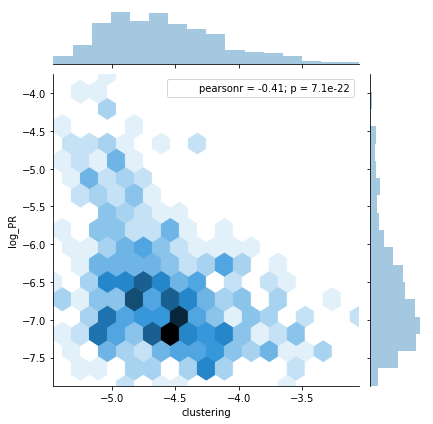

In [41]:
sns.jointplot('clustering', 'log_PR', data=node_df, kind='hex')

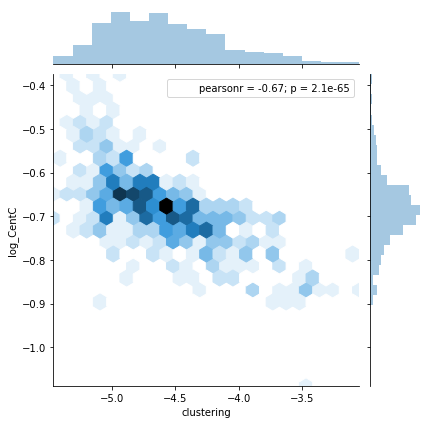

In [42]:
sns.jointplot('clustering', 'log_CentC', data=node_df, kind='hex')

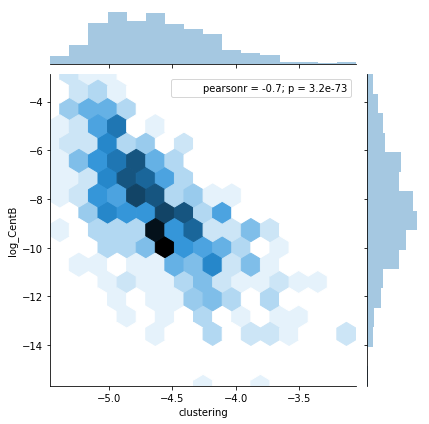

In [43]:
sns.jointplot('clustering', 'log_CentB', data=node_df, kind='hex')

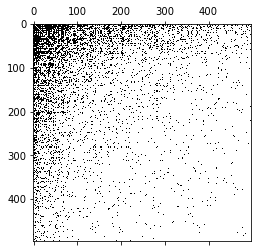

In [44]:
plt.spy(coocc.values)

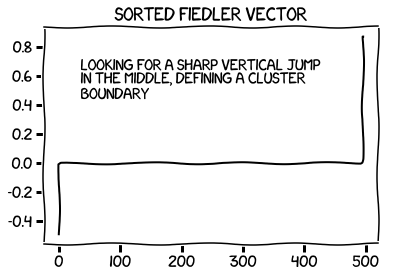

In [45]:
import matplotlib
matplotlib.font_manager._rebuild()

with plt.xkcd():
    plt.title('sorted fiedler vector')
    fied = nx.fiedler_vector(G)
    plt.plot(np.arange(fied.shape[0]),np.sort(nx.fiedler_vector(G)), 'k')
    # place a text box in upper left in axes coords
    plt.text(0.1, 0.85, ' Looking for a sharp vertical jump\n in the middle, defining a cluster\n boundary',
             transform=plt.gca().transAxes, fontsize=14, verticalalignment='top'
            )
# arrangement = np.argsort(nx.fiedler_vector(G))

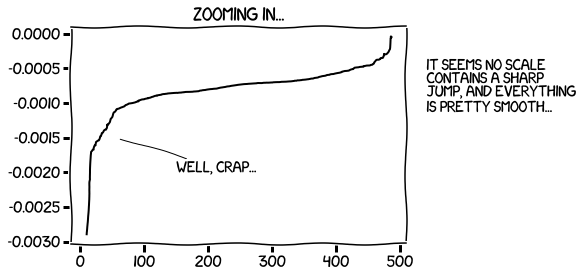

In [46]:
with plt.xkcd():
    plt.title('zooming in...')
    fied = nx.fiedler_vector(G)
    plt.plot(np.arange(fied.shape[0])[10:-10],np.sort(fied)[10:-10], 'k')
    plt.annotate(
        'well, crap...',
        xy=(60,-.0015), arrowprops=dict(arrowstyle='-'), xytext=(150, -.002)
    )
    plt.text(1.05, 0.85, ' It seems no scale\n contains a sharp\n jump, and everything\n is pretty smooth...',
         transform=plt.gca().transAxes, fontsize=14, verticalalignment='top'
        )
#     plt.yscale('symlog', linthresy=(-.0010, -.0005))

In [47]:
nx.spectral_ordering(G, weight=None)

['inverter_guard',
 'table_down_sensor',
 'unit_safety',
 'brush_unit_safety',
 'unit_safety_guard',
 'safety_guard',
 'dresser_control_valve',
 'dresser_control',
 'platform',
 'loader_tray',
 'pneumatic',
 'i_2',
 'door_interlock',
 'vogel_unit',
 'filtermist',
 'valve_stem',
 'recess_unit',
 'valve_plate',
 'chip_guard',
 'chip_conveyor_belt',
 'high_pressure_coolant_hose',
 'stripper',
 'chip_stripper',
 'iemca_flag',
 'hook',
 'battery',
 'wheel_control_valve',
 'mist',
 'bar_loader_chain',
 'draw_bar',
 'impellor',
 'st_2_drill_detector',
 'flag_proximity_cable',
 'direct_current',
 'speed_counter',
 'skimmer',
 'drawbar',
 'high_pressure_accumulator',
 'bar_feed',
 'wide',
 'exit_conveyor',
 'loader_chain',
 'sinico',
 'clamp pressure',
 'horseshoe',
 'st_2_drill',
 'offload_conveyor_belt',
 'head_attachment',
 'iso_46',
 'hinge_belt',
 'saw_blade',
 'separator',
 'hose_connection',
 'inverter_valve',
 'pad',
 'chuck_cylinder',
 'exit_chute',
 'st_3_spindle',
 'skirt',
 'intake_

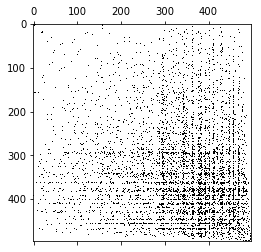

In [48]:
plt.spy(coocc.loc[nx.spectral_ordering(G, weight=None),
                  nx.spectral_ordering(G, weight=None)])

In [49]:
from networkx.readwrite import json_graph
from networkx.algorithms.traversal.depth_first_search import dfs_tree
import json

subD = dfs_tree(D, 'unit')

with open('d3tree.json', 'w') as outfile:
    s=json.dump(json_graph.tree.tree_data(subD, 'unit'), outfile)

In [50]:
%%writefile f2.template
<!DOCTYPE html>
<meta charset="utf-8">
<style>

.node {
  cursor: pointer;
}

.node circle {
  fill: #fff;
  stroke: steelblue;
  stroke-width: 1.5px;
}

.node text {
  font: 10px sans-serif;
}

.link {
  fill: none;
  stroke: #ccc;
  stroke-width: 1.5px;
}

</style>
<body>
<script src="//d3js.org/d3.v3.min.js"></script>
<script>

var margin = {top: 20, right: 120, bottom: 20, left: 120},
    width = 1500 - margin.right - margin.left,
    height = 1200 - margin.top - margin.bottom;

var i = 0,
    duration = 750,
    root;

var tree = d3.layout.tree()
    .size([height, width]);

var diagonal = d3.svg.diagonal()
    .projection(function(d) { return [d.y, d.x]; });

var svg = d3.select("body").append("svg")
    .attr("width", width + margin.right + margin.left)
    .attr("height", height + margin.top + margin.bottom)
  .append("g")
    .attr("transform", "translate(" + margin.left + "," + margin.top + ")");

d3.json("d3tree.json", function(error, flare) {
  if (error) throw error;

  root = flare;
  root.x0 = height / 2;
  root.y0 = 0;

  function collapse(d) {
    if (d.children) {
      d._children = d.children;
      d._children.forEach(collapse);
      d.children = null;
    }
  }

  root.children.forEach(collapse);
  update(root);
});

d3.select(self.frameElement).style("height", "1200px");

function update(source) {

  // Compute the new tree layout.
  var nodes = tree.nodes(root).reverse(),
      links = tree.links(nodes);

  // Normalize for fixed-depth.
  nodes.forEach(function(d) { d.y = d.depth * 180; });

  // Update the nodes…
  var node = svg.selectAll("g.node")
      .data(nodes, function(d) { return d.id || (d.id = ++i); });

  // Enter any new nodes at the parent's previous position.
  var nodeEnter = node.enter().append("g")
      .attr("class", "node")
      .attr("transform", function(d) { return "translate(" + source.y0 + "," + source.x0 + ")"; })
      .on("click", click);

  nodeEnter.append("circle")
      .attr("r", 1e-6)
      .style("fill", function(d) { return d._children ? "lightsteelblue" : "#fff"; });

  nodeEnter.append("text")
      .attr("x", function(d) { return d.children || d._children ? -10 : 10; })
      .attr("dy", ".35em")
      .attr("text-anchor", function(d) { return d.children || d._children ? "end" : "start"; })
      .text(function(d) { return d.id; })
      .style("fill-opacity", 1e-6);

  // Transition nodes to their new position.
  var nodeUpdate = node.transition()
      .duration(duration)
      .attr("transform", function(d) { return "translate(" + d.y + "," + d.x + ")"; });

  nodeUpdate.select("circle")
      .attr("r", 4.5)
      .style("fill", function(d) { return d._children ? "lightsteelblue" : "#fff"; });

  nodeUpdate.select("text")
      .style("fill-opacity", 1);

  // Transition exiting nodes to the parent's new position.
  var nodeExit = node.exit().transition()
      .duration(duration)
      .attr("transform", function(d) { return "translate(" + source.y + "," + source.x + ")"; })
      .remove();

  nodeExit.select("circle")
      .attr("r", 1e-6);

  nodeExit.select("text")
      .style("fill-opacity", 1e-6);

  // Update the links…
  var link = svg.selectAll("path.link")
      .data(links, function(d) { return d.target.id; });

  // Enter any new links at the parent's previous position.
  link.enter().insert("path", "g")
      .attr("class", "link")
      .attr("d", function(d) {
        var o = {x: source.x0, y: source.y0};
        return diagonal({source: o, target: o});
      });

  // Transition links to their new position.
  link.transition()
      .duration(duration)
      .attr("d", diagonal);

  // Transition exiting nodes to the parent's new position.
  link.exit().transition()
      .duration(duration)
      .attr("d", function(d) {
        var o = {x: source.x, y: source.y};
        return diagonal({source: o, target: o});
      })
      .remove();

  // Stash the old positions for transition.
  nodes.forEach(function(d) {
    d.x0 = d.x;
    d.y0 = d.y;
  });
}

// Toggle children on click.
function click(d) {
  if (d.children) {
    d._children = d.children;
    d.children = null;
  } else {
    d.children = d._children;
    d._children = null;
  }
  update(d);
}

</script>

Overwriting f2.template


In [51]:
from IPython.display import IFrame
import re

def replace_all(txt,d):
    rep = dict((re.escape('{'+k+'}'), str(v)) for k, v in d.items())
    pattern = re.compile("|".join(rep.keys()))
    return pattern.sub(lambda m: rep[re.escape(m.group(0))], txt)    

count=0
def serve_html(s,w,h):
    import os
    global count
    count+=1
    fn= '__tmp'+str(os.getpid())+'_'+str(count)+'.html'
    with open(fn,'w') as f:
        f.write(s)
    return IFrame('files/'+fn,w,h)

def f2(w=500,h=400):
    d={
       'width'      :w,
       'height'     :h,
       }
    with open('f2.template','r') as f:
        s=f.read()
    s= replace_all(s,d)        
    return serve_html(s,w+30,h+30)

In [52]:
f2(w=1500,h=1200)

# Questions/Comments?